In [1]:
import os
import numpy
import pandas
import pathlib
from intervaltree import Interval, IntervalTree
from Bio import SeqIO
import pickle
import statistics as stats
import logging
from datetime import datetime

In [2]:
matrix_path = pathlib.Path("/home/mf019/longread_pangenome/expanded_dataset_analysis/output/alignments/ava/v4/nucl_v5.coords.tab")
multifasta = pathlib.Path("/home/mf019/longread_pangenome/expanded_dataset_analysis/assemblies/all_contigs_v5_fixed.fna")

In [3]:
lengths = {}
for record in SeqIO.parse(multifasta, "fasta"):
    lengths[record.id] = len(record.seq)

In [4]:
# "When run with the -B option, output format will consist of 21 tab-delimited columns. These are as follows: 
# [1] query sequence ID 
# [2] date of alignment 
# [3] length of query sequence 
# [4] alignment type 
# [5] reference file 
# [6] reference sequence ID 
# [7] start of alignment in the query 
# [8] end of alignment in the query 
# [9] start of alignment in the reference 
# [10] end of alignment in the reference 
# [11] percent identity 
# [12] percent similarity 
# [13] length of alignment in the query 
# [14] 0 for compatibility 
# [15] 0 for compatibility 
# [16] NULL for compatibility 
# [17] 0 for compatibility 
# [18] strand of the query 
# [19] length of the reference sequence 
# [20] 0 for compatibility 
# [21] and 0 for compatibility."

header = [ 
    "query_ID", "aln_date", "query_len", "aln_type",
    "ref_file","ref_ID","aln_start_query","aln_end_query",
    "aln_start_ref","aln_end_ref","percent_identity","percent_similarity",
    "aln_len_query","0_compatibility_1","0_compatibility_2","NULL_compatibility",
    "0_compatibility_3", "strand_query", "reference_len", "0_compatibility_4",
    "0_compatibility_5",
]

In [5]:
aln_df = pandas.read_csv(matrix_path, sep='\t', names=header)
alns_slim_df = aln_df[[
    "query_ID", "query_len", "ref_ID", "reference_len", 
    "aln_start_query", "aln_end_query", 
    "aln_start_ref", "aln_end_ref",
    "percent_identity", "percent_similarity",
    "aln_len_query", "strand_query"]]

In [6]:
#.groupby('query_ID')
#alns_slim_df.apply(lambda x: tuple(sorted([x['ref_contig'], x['query_contig'])), axis=1)
alns_slim_df['pair'] = alns_slim_df.apply(lambda x: tuple(sorted([x['query_ID'], x['ref_ID']])), axis=1)

/tmp/ipykernel_10949/3187840248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alns_slim_df['pair'] = alns_slim_df.apply(lambda x: tuple(sorted([x['query_ID'], x['ref_ID']])), axis=1)


In [7]:
test_df = alns_slim_df[alns_slim_df['pair'].isin([('B331P__contig_1', 'B331P__contig_1'),('B331P__contig_1', 'B418P__contig_1'), ('B331P__contig_1', 'B500P__contig_1'), ('B331P__contig_1', 'B331P__contig_14')])]

In [8]:
def normalize_intervals(intervals):
   """Ensure intervals are normalized with 1-based coordinates"""
   return [(min(start, end), max(start, end)) for start, end in intervals]

def get_overlap_length(iv1, iv2):
   """Calculate overlap between two intervals considering 1-based coordinates"""
   start = max(iv1[0], iv2[0])
   end = min(iv1[1], iv2[1])
   return max(0, end - start + 1)  # +1 for inclusive ends

def collapse_intervals(intervals):
   """Collapse overlapping intervals into non-overlapping regions"""
   normalized = normalize_intervals(intervals)
   tree = IntervalTree(Interval(start, end + 1) for start, end in normalized)
   tree.merge_overlaps()
   return [(iv.begin, iv.end - 1) for iv in sorted(tree)]
    
def calculate_total_weighted_overlap(aln_pair_string, query_intervals, ref_intervals, percent_identities, logger):
   """Calculate total overlap between two sets of intervals."""
   logger.info(aln_pair_string)
   # First normalize and create original data
   original = [(min(start, end), max(start, end), identity) 
               for (start, end), identity in zip(query_intervals, percent_identities)]
   
   # Then collapse to get unique regions
   collapsed_query_intervals = collapse_intervals(query_intervals)
   collapsed_reference_intervals = collapse_intervals(ref_intervals)

   # Log the intervals being processed
   logger.info("Processing original intervals:")
   for s, e, i in original:
       logger.debug(f"Original: {s}-{e} ({i}%)")
   
   logger.info("Collapsed intervals:")
   for s, e in collapsed_query_intervals:
       logger.debug(f"Collapsed: {s}-{e}")

   # Check for perfect self alignment
   max_len = max(e-s+1 for s,e,_ in original)
   perfect = next(((s,e,i) for s,e,i in original if i == 100.0 and e-s+1 == max_len), None)
   
   if perfect:
       length = perfect[1] - perfect[0] + 1
       logger.info(f"Perfect self alignment found: {perfect[0]}-{perfect[1]}, len={length}")
       return (length, collapsed_query_intervals, collapsed_reference_intervals,
               [length], [length], 100.0)

   # For non-self alignments:
   total_weighted_overlap = 0
   idents = []
   
   # For each collapsed interval
   for c_start, c_end in collapsed_query_intervals:
       c_length = c_end - c_start + 1
       
       # Find all original intervals that overlap this collapsed interval
       overlapping_identities = []
       for o_start, o_end, o_identity in original:
           # Check if intervals overlap
           if not (o_end < c_start or o_start > c_end):
               overlapping_identities.append(o_identity)
       
       # Use highest identity score for this region
       if overlapping_identities:
           best_identity = max(overlapping_identities)
           weighted = c_length * (best_identity/100.0)
           total_weighted_overlap += weighted
           idents.append(best_identity)
           logger.debug(f"Collapsed {c_start}-{c_end}: len={c_length}, best_id={best_identity}, weighted={weighted}")

   logger.info(f"Total weighted overlap: {total_weighted_overlap}")

   return (
       round(total_weighted_overlap),
       collapsed_query_intervals,
       collapsed_reference_intervals,
       [end-start+1 for start,end in collapsed_query_intervals],
       [end-start+1 for start,end in collapsed_reference_intervals],
       stats.mean(idents)
   )

In [9]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_filename = f'MUMmer_parsing_{timestamp}.log'

logger = logging.getLogger('main')
logger.setLevel(logging.DEBUG)

fh = logging.FileHandler(log_filename)
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)

results = []
for (query_id, ref_id), group in alns_slim_df.groupby(["query_ID", "ref_ID"]): # test_df
    # Extract query and reference intervals
    query_intervals = list(zip(group["aln_start_query"], group["aln_end_query"]))
    ref_intervals = list(zip(group["aln_start_ref"], group["aln_end_ref"]))
    percent_identities = group["percent_identity"].tolist()
    aln_pair_string = f'QUERY:{query_id}, REF:{ref_id}'
    # Calculate total weighted overlap and interval lengths
    (
        total_overlap,
        collapsed_query,
        collapsed_ref,
        query_interval_lengths,
        ref_interval_lengths,
        mean_identity,
    ) = calculate_total_weighted_overlap(aln_pair_string, query_intervals, ref_intervals, percent_identities, logger)

    query_interval_len = sum(query_interval_lengths)
    ref_interval_len = sum(ref_interval_lengths)
    query_len = lengths[query_id]
    ref_len = lengths[ref_id]
    edge_weight = ((2*total_overlap)/(lengths[ref_id] + lengths[query_id]))
    # or(query_interval_len != ref_interval_len) idk about this one boss.
    flag = 1 if (total_overlap > query_len) or (total_overlap > ref_len) or (edge_weight > 1.0) or (query_interval_len > query_len) or (total_overlap < ((mean_identity/100) * min(query_interval_len, ref_interval_len))) or (ref_interval_len > ref_len) else 0
    # Store results
    results.append({
        "query_ID": query_id,
        "ref_ID": ref_id,
        "total_weighted_overlap": total_overlap,
        "mean_identity": mean_identity,
        "edge_weight": edge_weight,
        'query_len': query_len,
        'ref_len': ref_len,
        "query_interval_len": query_interval_len,
        "ref_interval_len": ref_interval_len,
        "collapsed_query_intervals": collapsed_query,
        "collapsed_ref_intervals": collapsed_ref,
        "flag": flag
    })

results_df = pandas.DataFrame(results)
logging.shutdown()

In [10]:
print(results_df)

                  query_ID              ref_ID  total_weighted_overlap  \
0          B331P__contig_1     B331P__contig_1                  903654   
1          B331P__contig_1    B331P__contig_14                     656   
2          B331P__contig_1     B418P__contig_1                  898703   
3          B331P__contig_1     B500P__contig_1                  903564   
4          B331P__contig_1    ESI26H__contig_1                  898537   
...                    ...                 ...                     ...   
2142122  XYZ459H__contig_9   XYZ459H__contig_2                    1084   
2142123  XYZ459H__contig_9  XYZ459H__contig_20                     388   
2142124  XYZ459H__contig_9  XYZ459H__contig_21                     441   
2142125  XYZ459H__contig_9   XYZ459H__contig_5                   17899   
2142126  XYZ459H__contig_9   XYZ459H__contig_9                   27704   

         mean_identity  edge_weight  query_len  ref_len  query_interval_len  \
0           100.000000     1.000

In [11]:
results_df[results_df['query_ID'] == 'B331P__contig_14']

,query_ID,ref_ID,total_weighted_overlap,mean_identity,edge_weight,query_len,ref_len,query_interval_len,ref_interval_len,collapsed_query_intervals,collapsed_ref_intervals,flag
2486,B331P__contig_14,B331P__contig_1,656,78.978622,0.001416,23102,903654,830,830,"[(9197, 10026)]","[(774678, 775507)]",0
2487,B331P__contig_14,B331P__contig_12,2520,83.415924,0.105386,23102,24722,3021,3021,"[(5961, 8981)]","[(1229, 4249)]",0
2488,B331P__contig_14,B331P__contig_13,3687,90.850361,0.145321,23102,27641,4199,4205,"[(3, 1209), (5965, 8956)]","[(3354, 6345), (26427, 27639)]",1
2489,B331P__contig_14,B331P__contig_14,23102,100.000000,1.000000,23102,23102,23102,23102,"[(1, 23102)]","[(1, 23102)]",0
2490,B331P__contig_14,B331P__contig_15,1135,84.773953,0.043329,23102,29288,1342,1343,"[(5125, 5659), (22115, 22921)]","[(170, 974), (27357, 27894)]",1
...,...,...,...,...,...,...,...,...,...,...,...,...
3290,B331P__contig_14,XYZ459H__contig_1,657,79.097382,0.001418,23102,903233,830,830,"[(9197, 10026)]","[(774359, 775188)]",0
3291,B331P__contig_14,XYZ459H__contig_11,3169,82.582817,0.134966,23102,23858,3837,3848,"[(5176, 9012)]","[(19842, 23689)]",0
3292,B331P__contig_14,XYZ459H__contig_3,3280,83.742472,0.122249,23102,30559,3911,4748,"[(1437, 1603), (3518, 4034), (5786, 9012)]","[(778, 4009), (6220, 6730), (7975, 8979)]",0
3293,B331P__contig_14,XYZ459H__contig_6,920,95.634094,0.034756,23102,29839,962,961,"[(22115, 23076)]","[(3, 963)]",0


In [12]:
print(len(set(results_df['query_ID'])))
print(len(set(results_df['ref_ID'])))

4016
4016


In [13]:
with open('fixed_parsed_mummer_output.pkl', 'wb') as file:
    pickle.dump(results_df, file)

In [20]:
# Create a sorted pair column
results_df['sorted_pair'] = results_df.apply(lambda row: tuple(sorted([row['query_ID'], row['ref_ID']])), axis=1)

# Group by the sorted pair and take the row with the minimum total_weighted_overlap
filtered_df = results_df.loc[results_df.groupby('sorted_pair')['total_weighted_overlap'].idxmin()]

# Drop the helper column as it's no longer needed
filtered_df = filtered_df.drop(columns=['sorted_pair'])

# Display the filtered dataframe
print(filtered_df)

                  query_ID             ref_ID  total_weighted_overlap  \
0          B331P__contig_1    B331P__contig_1                  903654   
1          B331P__contig_1   B331P__contig_14                     656   
18949      B418P__contig_1    B331P__contig_1                  897953   
3          B331P__contig_1    B500P__contig_1                  903564   
53583     ESI26H__contig_1    B331P__contig_1                  898120   
...                    ...                ...                     ...   
2140129  XYZ459H__contig_6  XYZ459H__contig_6                   29839   
2140130  XYZ459H__contig_6  XYZ459H__contig_7                    1100   
2140856  XYZ459H__contig_7  XYZ459H__contig_7                   29476   
2140938  XYZ459H__contig_8  XYZ459H__contig_8                   28681   
2142126  XYZ459H__contig_9  XYZ459H__contig_9                   27704   

         mean_identity  edge_weight  query_len  ref_len  query_interval_len  \
0           100.000000     1.000000     9036

In [23]:
filtered_df = filtered_df.reset_index(drop=True)

In [24]:
print(len(set(filtered_df['query_ID'])))
print(len(set(filtered_df['ref_ID'])))

4016
4016


In [25]:
with open('fixed_parsed_mummer_output_dedup.pkl', 'wb') as file:
    pickle.dump(results_df, file)

In [27]:
edges_df = filtered_df[['query_ID', 'ref_ID', 'total_weighted_overlap', 'edge_weight', 'query_len', 'ref_len']]

In [35]:
edges_df = edges_df.rename(columns={
    'query_ID': 'Source',
    'ref_ID': 'Target',
    'edge_weight': 'weight',
    'query_len': 'source_length',
    'ref_len': 'target_length',
    'total_weighted_overlap': 'alignment_length',
})

In [36]:
edges_df['interaction'] = edges_df['weight'].apply(lambda x: 'interacts' if x>0 else 'none')

In [84]:
print(edges_df['interaction'].value_counts())
print(edges_df[edges_df['weight']== 1.1075697211155378])
# ok we're just gonna drop the weird ones.

interaction
interacts    1070313
Name: count, dtype: int64
                      Source              Target  alignment_length   weight  \
672947  UNY1083P__contig_118  URI56H__contig_215               278  1.10757   

        source_length  target_length interaction  
672947            377            125   interacts  


In [74]:
print(len(set(edges_df['Source'])))
print(len(set(edges_df['Target'])))
print(set(edges_df['Target']) - set(edges_df['Source']))#{'UNY1083P__contig_103', 'URI48H__contig_20', 'URI34H__contig_50', 'UNY1128P__contig_274', 'XYZ459H__contig_22', 'XYZ459H__contig_10', 'URI56H__contig_26', 'URI48H__contig_21', 'ESI26H__contig_13', 'URI48H__contig_22'}
print(set(edges_df['Source']) - set(edges_df['Target']))#{'UNY1128P__contig_272', 'UNY1083P__contig_135', 'UCT50H__contig_18', 'UCT35H__contig_32', 'UNY1083P__contig_226', 'URI33H__contig_34', 'ESI425H__contig_17', 'UCT35H__contig_28', 'ESI425H__contig_20', 'UNY1083P__contig_31', 'ESI403H__contig_30'}

3902
3901
{'UNY1083P__contig_103', 'URI48H__contig_20', 'URI34H__contig_50', 'UNY1128P__contig_274', 'XYZ459H__contig_22', 'XYZ459H__contig_10', 'URI56H__contig_26', 'URI48H__contig_21', 'ESI26H__contig_13', 'URI48H__contig_22'}
{'UNY1128P__contig_272', 'UNY1083P__contig_135', 'UCT50H__contig_18', 'UCT35H__contig_32', 'UNY1083P__contig_226', 'URI33H__contig_34', 'ESI425H__contig_17', 'UCT35H__contig_28', 'ESI425H__contig_20', 'UNY1083P__contig_31', 'ESI403H__contig_30'}


In [196]:
# No self alignments
edges_df = edges_df[~(edges_df['Source'] == edges_df['Target'])]

In [197]:
# No short contigs
filt_edges_df = edges_df[~((edges_df['source_length'] < 1500) | (edges_df['target_length'] < 1500))]

In [198]:
print(len(set(filt_edges_df['Source'])))#1681
print(len(set(filt_edges_df['Target'])))#1681
missing_from_target = set(filt_edges_df['Target']) - set(filt_edges_df['Source'])
missing_from_source = set(filt_edges_df['Source']) - set(filt_edges_df['Target'])

1562
1562


In [199]:
# and no weights below 0.5
filt05_edges_df = filt_edges_df[(filt_edges_df['weight'] >= 0.5)] # 0.5, 0.1, 0.09
print(len(set(filt05_edges_df['Source'])))#1567
print(len(set(filt05_edges_df['Target'])))#1568

# and no weights below 0.1
filt01_edges_df = filt_edges_df[(filt_edges_df['weight'] >= 0.1)]
print(len(set(filt01_edges_df['Source'])))#1666
print(len(set(filt01_edges_df['Target'])))#1671

# and no weights below 0.01
filt001_edges_df = filt_edges_df[(filt_edges_df['weight'] >= 0.01)] # going forward with this one but cutting off alignment length at 500
print(len(set(filt001_edges_df['Source'])))#1680
print(len(set(filt001_edges_df['Target'])))#1681

1475
1478
1555
1557
1561
1562


In [200]:
# and no aln lengths below 500bp
filt_w001_aln500_edges_df = filt001_edges_df[(filt001_edges_df['alignment_length'] >= 500)] # going forward with this one but cutting off alignment length at 500
print(len(set(filt_w001_aln500_edges_df['Source'])))#1561
print(len(set(filt_w001_aln500_edges_df['Target'])))#1562

1561
1562


In [201]:
filt_w001_aln500_edges_df.to_csv(f'fixed_nucl_v5_pd_matrix_filtered_w001_aln500_len1500_edges_{timestamp}.csv', sep=',', index=False)

In [155]:
import matplotlib.pyplot as plt

def plot_weight_histogram(df, cutoff):
    plt.hist(df['weight'], bins=100, edgecolor='black')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title(f'Weight Distribution ({cutoff})')
    # Add more ticks to the y-axis
    max_x = plt.gca().get_xlim()[1]  # Get the maximum value of the y-axis
    print(max_x)
    ticks = numpy.linspace(0, max_x, num=10)  # Adjust the number of ticks (e.g., 15)
    plt.xticks(ticks)
    return plt


1.1629456077460043


<module 'matplotlib.pyplot' from '/home/mf019/bin/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

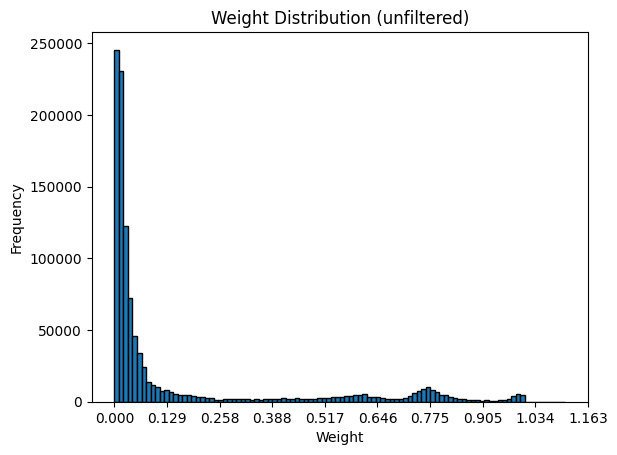

In [156]:
plot_weight_histogram(edges_df, "unfiltered")

1.025


<module 'matplotlib.pyplot' from '/home/mf019/bin/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

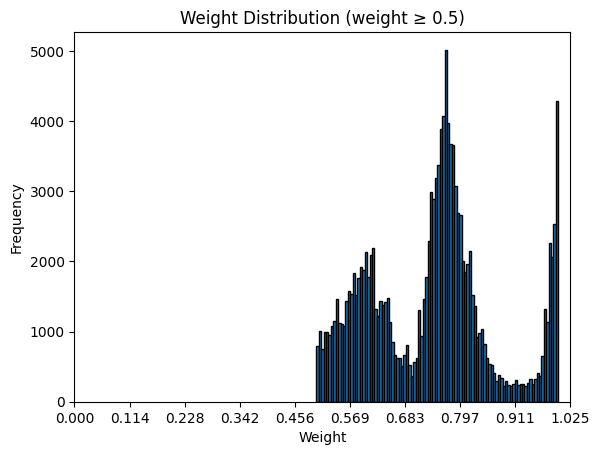

In [157]:
plot_weight_histogram(filt05_edges_df, "weight ≥ 0.5")

1.0449999152240628


<module 'matplotlib.pyplot' from '/home/mf019/bin/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

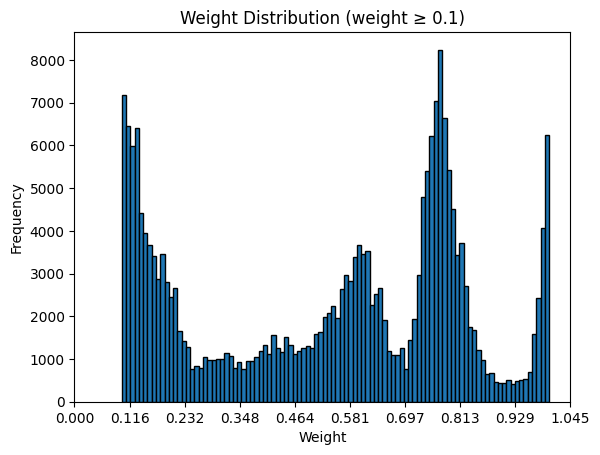

In [158]:
plot_weight_histogram(filt01_edges_df, "weight ≥ 0.1")

1.0494999473628803


<module 'matplotlib.pyplot' from '/home/mf019/bin/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

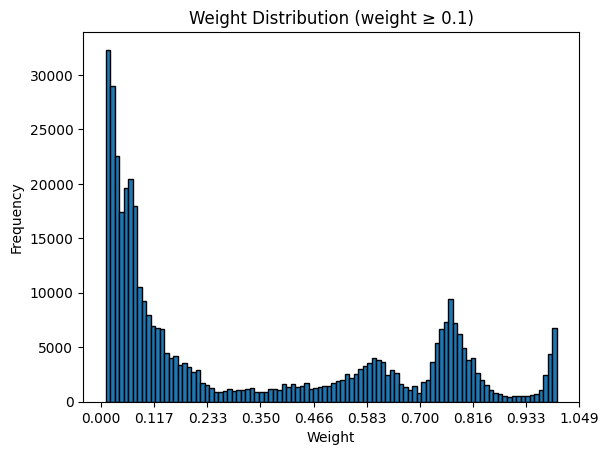

In [159]:
plot_weight_histogram(filt001_edges_df, "weight ≥ 0.1")

In [182]:
#print(filt_edges_df[filt_edges_df['Target']=='URI117H__contig_26'])
#print(filt_edges_df[filt_edges_df['Source']=='ESI425H__contig_17'])
print(filt_edges_df[filt_edges_df['Source']=='GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161185.1'])

                                                   Source              Target  \
6109    GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...     B331P__contig_2   
40428   GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...     B500P__contig_2   
82861   GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...    ESI26H__contig_9   
90844   GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...   ESI361H__contig_7   
92849   GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...  ESI403H__contig_11   
...                                                   ...                 ...   
323302  GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...   UWI263P__contig_1   
323303  GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...   UWI263P__contig_2   
323305  GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...   UWI283P__contig_2   
323306  GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...   XYZ459H__contig_1   
323307  GCF_040790775.1_ASM4079077v1_genomic__NZ_CP161...  XYZ459H__contig_10   

        alignment_length   